In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:60% !important; }</style>"))

In [2]:
## Standard libraries
import os
import math
import time
import numpy as np
import random
import copy

## Scikit-learn built-in dataset generator
from sklearn.datasets import make_blobs

## Progress bar
import tqdm

## Imports for plotting
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
plt.style.use('ggplot')

In [3]:
## Useful for creating GIFs
import imageio

## PyTorch
import torch
import torchvision

# Function for setting the seed
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

# device to be used for Parts II-IV is preferably a GPU
# try to change the runtime type to GPU if you can in Google Colab
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Using device", device)

Using device cuda:0


In [4]:
# the next lines define the architecture of the model and its functionality in forward path 
# (e.g how it operates when inputting an image)
class ResNet(torch.nn.Module):
    def __init__(self, n_channels):
        super().__init__()

        levels_params = [
            {'n_channels': 16, 'n_blocks': 2, 'downsample': False},
            {'n_channels': 32, 'n_blocks': 2, 'downsample': True},
            {'n_channels': 64, 'n_blocks': 2, 'downsample': True},
            {'n_channels': 64, 'n_blocks': 2, 'downsample': True},
            ]

        self._el = torch.nn.ModuleDict()

        self._el['in_conv'] = torch.nn.Conv2d(n_channels, 16, kernel_size=3, padding=3)
        n_channels = 16

        levels = torch.nn.ModuleList()
        for level_params in levels_params:
            level = torch.nn.ModuleDict()
            res_blocks = torch.nn.ModuleList()

            ## The first residual block in the level
            res_block = torch.nn.ModuleDict()
            n_channels_out = level_params['n_channels']
            if level_params['downsample']:
                res_block['shortcut_conv'] = torch.nn.Conv2d(n_channels, n_channels_out, kernel_size=2, stride=2)
            else:
                res_block['shortcut_conv'] = torch.nn.Conv2d(n_channels, n_channels_out, kernel_size=1)
            res_block['conv_1'] = torch.nn.Conv2d(n_channels, n_channels_out, kernel_size=3, padding=1)
            n_channels = n_channels_out
            if level_params['downsample']:
                res_block['conv_2'] = torch.nn.Conv2d(n_channels, n_channels, kernel_size=4, stride=2, padding=1)
            else:
                res_block['conv_2'] = torch.nn.Conv2d(n_channels, n_channels, kernel_size=3, stride=1, padding=1)
            res_blocks.append(res_block)

            ## The rest of the residual blocks in the level
            for _ in range(level_params['n_blocks'] - 1):
                res_block = torch.nn.ModuleDict()
                res_block['conv_1'] = torch.nn.Conv2d(n_channels, n_channels, kernel_size=3, padding=1)
                res_block['conv_2'] = torch.nn.Conv2d(n_channels, n_channels, kernel_size=3, padding=1)
                res_blocks.append(res_block)
            level['res_blocks'] = res_blocks
            levels.append(level)
        self._el['levels'] = levels

        self._el['out_fc'] = torch.nn.Linear(n_channels, 1, bias=False)

        for module in self.modules():
            if isinstance(module, torch.nn.Conv2d):
                torch.nn.init.xavier_uniform_(module.weight, gain=2 ** 0.5)
                if module.bias is not None:
                    module.bias.data.zero_()

    # functionality when inputting image x to the model:
    def forward(self, x):
        x = self._el['in_conv'](x)

        for level in self._el['levels']:
            for res_block in level['res_blocks']:
                shortcut = x
                x = torch.nn.functional.leaky_relu(x, 0.2)
                x = res_block['conv_1'](x)
                x = torch.nn.functional.leaky_relu(x, 0.2)
                x = res_block['conv_2'](x)
                if 'shortcut_conv' in res_block:
                    shortcut = res_block['shortcut_conv'](shortcut)
                x = x + shortcut

        x = torch.nn.functional.leaky_relu(x, 0.2)
        x = x.view(x.shape[0], x.shape[1], -1).sum(dim=2)
        x = self._el['out_fc'](x)

        return x[:, 0]

In [5]:
# instantiate the class above for images with 1 channel and load it to the device (CPU/GPU)
ebm = ResNet(n_channels=1).to(device)

# transfer the model to evaluation mode (as we don't want to train it, just to use it)
ebm.eval()

# load the trained model weights/parameters from the checkpoint file
checkpoint_path = 'checkpoint.pt'
ebm.load_state_dict(torch.load(checkpoint_path, map_location=device))

<All keys matched successfully>

In [6]:
def show_random_imgs(imgs, title, width=4, height=2, figsize=(14,7), all_idx=False):
    N = imgs.shape[0]
    if all_idx:
        indices = list(range(0,30))
    else:
        indices = np.random.choice(N, size=N, replace=False)
    fig, axes = plt.subplots(height, width, figsize=figsize, sharex=True, sharey=True)
    for i in range(width * height):
        m = i%width
        n = i//width
        axes[n,m].imshow(to_np(imgs[indices[i]][0]), cmap='gray')
    fig.suptitle(title, fontsize=40)
    plt.show()

In [7]:
def to_np(x):
    return x.clone().cpu().detach().numpy()

In [9]:
noisy_digits_25 = torch.load('noisy_digits_25_new.pt').to(device).requires_grad_(True)
noisy_digits_50 = torch.load('noisy_digits_50_new.pt').to(device).requires_grad_(True)

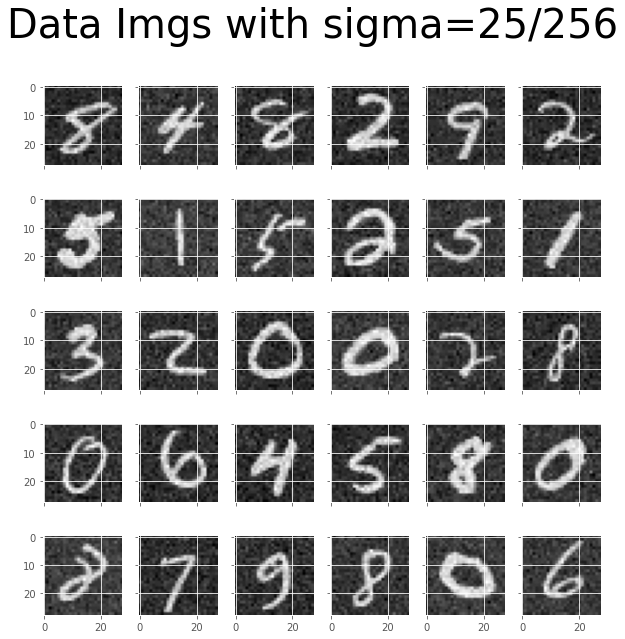

In [10]:
show_random_imgs(imgs=noisy_digits_25, title='Data Imgs with sigma=25/256', width=6, height=5, all_idx=True, figsize=(10,10))

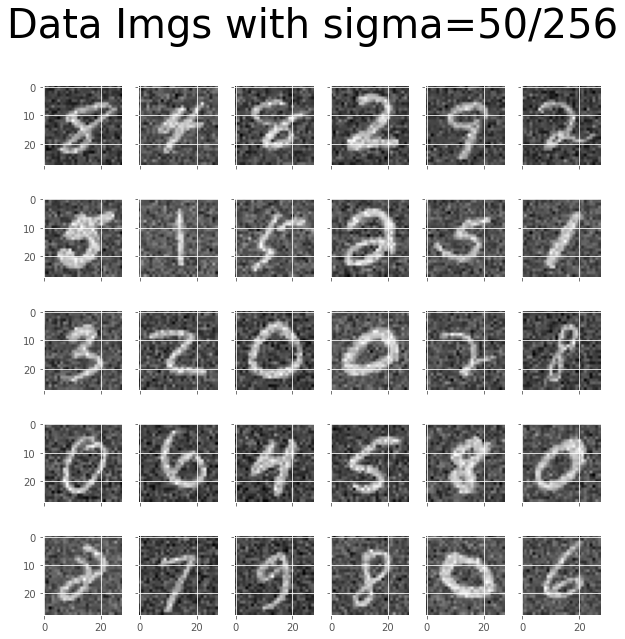

In [11]:
show_random_imgs(imgs=noisy_digits_50, title='Data Imgs with sigma=50/256', width=6, height=5, all_idx=True, figsize=(10,10))

In [12]:
def perceptual_denoising(imgs, K=2000, factored_epsilon = 2/256, sigma=50/256):
    y = torch.clone(imgs).to(device)
    x = torch.clone(imgs).to(device).requires_grad_(True)
    energy = ebm(imgs)
    grad_ebm = -torch.autograd.grad(energy.sum(), imgs)[0]
    epsilon = (factored_epsilon ** 2) / 2
    for k in tqdm.tqdm(range(K)):

        grad = (y - x)/(sigma**2) + grad_ebm
        noise = torch.randn(imgs.shape).to(device)
        x = x + epsilon * grad + factored_epsilon * noise
        energy = ebm(x)
        grad_ebm = -torch.autograd.grad(energy.sum(), x)[0]
        
    return x

In [15]:
l = []
for n in range(30):
    for i in range(6): 
        for j in range(6): 
            l.append((noisy_digits_25[n][0][27-i][27-j]).item())
print('estimated sigma by bottom left corner of noisy_digits_25: ', str(np.round(np.array(l).std() * 256,1))+'/256')

l = []
for n in range(30):
    for i in range(6): 
        for j in range(6): 
            l.append((noisy_digits_50[n][0][27-i][27-j]).item())
print('estimated sigma by bottom left corner of noisy_digits_50: ', str(np.round(np.array(l).std() * 256,1))+'/256')

estimated sigma by bottom left corner of noisy_digits_25:  24.9/256
estimated sigma by bottom left corner of noisy_digits_50:  49.2/256


In [20]:
img_25_de = perceptual_denoising(imgs=noisy_digits_25, K=2000, factored_epsilon=2/256, sigma=(25/256))

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:40<00:00, 48.88it/s]


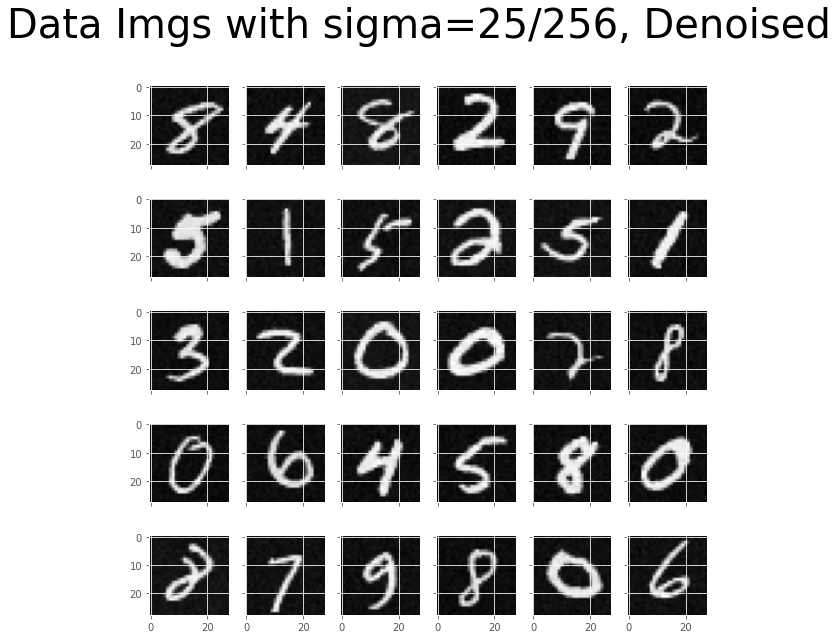

In [21]:
show_random_imgs(imgs=img_25_de, title='Data Imgs with sigma=25/256, Denoised', width=6, height=5, all_idx=True, figsize=(10,10))

In [22]:
img_50_de = perceptual_denoising(imgs=noisy_digits_50, K=2000, factored_epsilon=2/256, sigma=(50/256))

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:46<00:00, 42.66it/s]


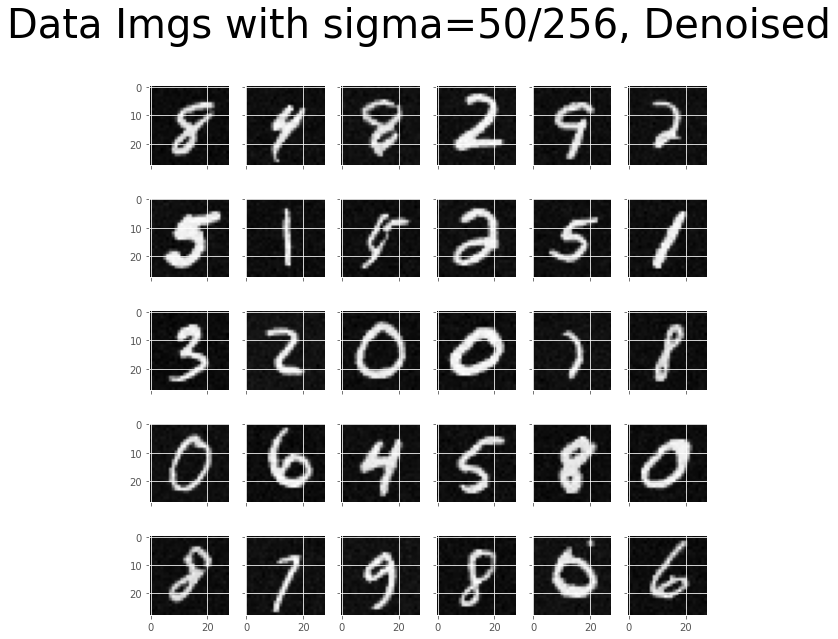

In [23]:
show_random_imgs(imgs=img_50_de, title='Data Imgs with sigma=50/256, Denoised', width=6, height=5, all_idx=True, figsize=(10,10))

In [24]:
def mmse(imgs, N=10, K=2000, factored_epsilon=2/256, sigma=50/256):
    res = torch.zeros(imgs.shape).to(device)
    for n in range(N):
        res += perceptual_denoising(imgs, K=K, factored_epsilon = factored_epsilon, sigma=sigma)
    return res / N

In [25]:
clean = mmse(imgs=noisy_digits_50, K=2000, N=10, sigma=50/256)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:37<00:00, 53.35it/s]


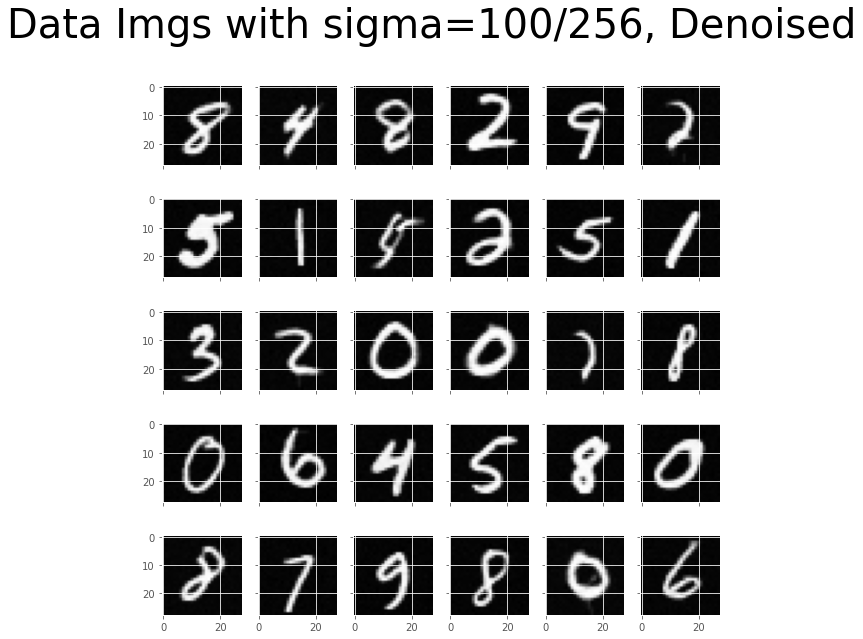

In [26]:
show_random_imgs(imgs=clean, title='Data Imgs with sigma=100/256, Denoised', width=6, height=5, figsize=(10,10), all_idx=True)

## $\color{#007FFF}{\textbf{Discussion:}}$
While the denoising of the $\sigma=\frac{25}{256}$ performed with no significats flaws, the case with $\sigma=\frac{50}{256}$ distorted the digits somewhat. $$ $$
With the usage of the mmse the results was improved and the distortions was mitigated.